# Flip User Guide

This is live document. You need to run all cells first to see the notebook in action: just select *Run all* or  icon with two arrows pointing to the right (JypiterLive) to Restart the kernel and run all cells.

## About Flip
* FLIP is Python Module for Parametric Structural Beam & Frame Analysis
* Target audience are students & engineers who want to think & code, not click
* Flip is licensed under GNU GPL-3.0 license
* Flip was developped by [Bořek Patzák](https://mech.fsv.cvut.cz/~bp)


## Installation
The project is pure Python and depends only on a small set of lightweight libraries.

### Installing Flip on your computer
* Clone the repository

    ```bash
    git clone https://github.com/bpatzak/flip.git
    cd flip
    ```

* Create a virtual environment (recommended)

    ```bash
    python3 -m venv venv
    source venv/bin/activate   # Linux/macOS
    venv\Scripts\activate      # Windows
    ```

* Install dependencies

    ```bash
    pip install -r requirements.txt
    ```

## Using Flip.live 
* You can try Flip in your browser (no installation necassary) on [Flip.live site](https://bpatzak.github.io/flip.live/lab/index.html?path=Welcome.ipynb)

## Getting started

### Importing Flip module
To get started using Flip you first need to import Flip as module

In [1]:
%pip install drawsvg
import sys
sys.path.append("..")
import flip

Note: you may need to restart the kernel to use updated packages.


### Create Domain
To define your model, you typically create an instance of `Solver` which represent the problem stored and ask `Solver` instance for its `Domain`, that holds your problem definition.

In [2]:
solver = flip.Solver()
domain = solver.domain

### Adding nodes, materials, cross sections & elements
We need to create individual components and add them into `Domain`

#### Nodes
To create a node, we create an instance of `Node` class. The syntax is 

```Python
Node (label, domain, coords=None, bcs=None, lcs=None)
```

where 
* *label* is unique identifier of the node used to refer to that node from other components
* *domain* is reference to the `Domain`
* *coords* is sequence of three coordinates (note that the structure is assumed to be defined in xz plane)
* *bcs* is sequence defining the restrained DOFs
* *lcs* is dict containing definition of node local coordinate system, containin 'lx' and 'ly' keys with values defining the vectors in local x and y directions. 

For example


In [3]:
flip.Node(1, domain, coords=(0.0, 0.0, 0.0))
flip.Node(2, domain, coords=(1.0, 0.0, 0.0), bcs=(flip.DofID.Dz,)) # node at (1,0,0) fixed in z direction
flip.Node(3, domain, coords=(1.0, 0.0, 0.0), bcs=(flip.DofID.Dy, flip.DofID.Dz, flip.DofID.Ry)) # node at (1,1,0) clamped 
flip.Node('node4', domain, coords=(0.0, 0.0, 1.0), lcs={'lx': (0.8660254037844387, 0.0, 0.5), 'ly': (0.0, 1.0, 0.0)}) # node at (0,0,1) with local coordinate system (rotated 30 degrees about y axis)


##### Adding nodes to domain

In [4]:
domain.add_node(flip.Node(1, domain, coords=[0.0, 0.0, 0.0], bcs=[flip.DofID.Dx, flip.DofID.Dz, flip.DofID.Ry]))
domain.add_node(flip.Node(2, domain, coords=[3.0, 0.0, 0.0], bcs=[flip.DofID.Dx, flip.DofID.Dz]))

#### Materials & cross sections
Materials are holding material data. You can create any number of materials in your model

```python
Material(label, e=1.0, g=1.0, alpha=1.0, d=1.0)
```
* *label* is unique identifier of the material used to refer to it from other components
* *e* Young's modulus 
* *g* Shear mohulus
* *alpha* optional thermal expansion coefficient
* *d* optional material density



In [5]:
m1 = flip.Material('Steel', e=200e9, g=80e9, d=7850, alpha = 1.2e-5)
m2 = flip.Material('c30', e=30.e9, g=12e9)
## Adding material to domain
domain.add_material(m1)
domain.add_material(m2)

##### Cross sections
Cross sections are holding cross section properties. You can create any number of cros ssections in your model
```python
CrossSection(label, a=None, iy=None, h=None, k=1.e30)
```
* *label* is unique identifier of the cross section used to refer to it from other components
* *a* defines cross section area
* *iy* defines cross section moment of inertia (with respect to local y axis)
* *h* defines the cross ssection height
* *k* defines shear correction factor (1.e30 by default to not consider the shear influence)


In [6]:
cs = flip.CrossSection("cs01", a=0.02, iy=8e-6)
domain.add_cs(cs)

#### Elements
* At present, Flip comes with *Beam2d* element only, representing 2D beam in x-z plane
* The element geometry is defined by two nodes
* The local x-axis of the element is defined as unit vector pointing from first element node (n1) to the second node (n2), ie. ${1\over l}\{n_2.x-n_1.x, n_2.z-n_1.z\}$, where $l$ is element length. Local y-axis is always (0,1,0)
* The element can have internal hinges at one or both ends.

```python
Beam2D(label, domain, nodes, mat, cs, hinges=(False, False))
```
* *label* is unique identifier of the element used to refer to it from other components
* *domain* reference to the *Domain*
* *nodes* sequence of element nodes defining its geometry
* *mat* defines element material (label of material)
* *cs* reference to cross section (label) defining element cross sectional properties
* *hinges* optional sequence defining whether element has internal hinge at start and end node. Default is no hinges. 

In [7]:
flip.Beam2D(1, domain, nodes=[1, 2], mat="C30", cs="rect", hinges=(False, False))
flip.Beam2D(2, domain, nodes=[2, 3], mat="C30", cs="rect", hinges=(False, True))
# Adding element to domain
e = flip.Beam2D(1, domain, nodes=(1, 2), mat="c30", cs="cs01")
domain.add_element(e)

## Boundary conditions
### Prescribed displacements
To impose prescribed displacement/rotation at restrained DOFs use *Domain.apply_prescribed_displacement* method:
```python
Domain.apply_prescribed_displacement(node_label, fofvalues)
```
* *node_label* defines node (by label) whose prescribed displacements/rotations are defined
* *dofvalues* dict of dict of dof → value defineing prescribed value for individual DOFs 


In [8]:
domain.apply_prescribed_displacement(2, {flip.DofID.Dz: 1.e-5})  # Apply a vertical displacement of 0.01 at node 2:

### Nodal Loads
Concentrated nodal loads 

```python
Domain.apply_nodal_load(self, node_label, fx=0.0, fz=0.0, My=0.0)
```
* *node_label* label of the node where the load is applied to
* *fx* load component in x-direction
* *fz* load component in z direction
* *My* moment loading

**Note that loading components are to be defined in global coordinate system. If the local coodinate system is defined for node, the loading components are to be defined in local coordinate system in the node.**


In [9]:
domain.apply_nodal_load(2, My=-2)  # Apply a verical force of 1000 N at node 2

### Element loads
The following element loads are supported:
* Concentrated load 
* Constant distributed load
* Temperature load, Prestress load and Linear distributed load are to be supported soon

#### Element Concentrated load
```python
PointLoadOnElement(fx=0.0, fz=0.0, a=0.0, local=False):
```
* *fx, fz* define x and z components of concentrated load
* *a* defines the position of concentrated load (measured from element beginning (node 1) along local x-axis)
* *local* whether the components are defined in element-local or global coordinate system



In [10]:
load = flip.PointLoadOnElement(fz=4, a=1.0)  # Apply a vertical load of 40 at x=1.0 
domain.apply_element_load(1, load) # Apply load to element 1

#### Constant distributed Load

```python
UniformDistributedLoad (fx=0.0, fz=0.0, local=False)
```
* *fx, fz* define the load intensities in z and z directions
* *local* hether the components are defined in element-local or global coordinate system


In [11]:
udl = flip.UniformDistributedLoad(fz=4.0)  # 
domain.apply_element_load(1, udl)

## Solving the problem

To solve the problem, simply call *Solver.solve* method

In [12]:
solver.solve()

Solution took 0.001 sec


array([9.02777778e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e-05])

### Postprocessing

Flip provides high-level graphical interface that allows 
* to generate plot of structure geometry with applied loads and boundary conditions
* to plot deformed shape
* to plot internal forces and moments diagrams, with exact detection of min/max values

It provides high-quality vector graphics in SVG format.


Solution took 0.002 sec


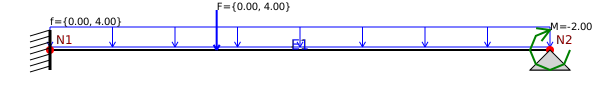

In [13]:

solver = flip.Solver()
domain = solver.domain

domain.add_node(flip.Node(1, domain, coords=[0.0, 0.0, 0.0], bcs=[flip.DofID.Dx, flip.DofID.Dz, flip.DofID.Ry]))
domain.add_node(flip.Node(2, domain, coords=[3.0, 0.0, 0.0], bcs=[flip.DofID.Dx, flip.DofID.Dz]))

domain.add_material(flip.Material('c30', e=30.e9, g=12e9))
domain.add_cs(flip.CrossSection("cs01", a=0.02, iy=8e-6))
domain.add_element(flip.Beam2D(1, domain, nodes=(1, 2), mat="c30", cs="cs01"))
domain.apply_prescribed_displacement(2, {flip.DofID.Dz: 1.e-5})  # Apply a vertical displacement of 0.01 at node 2:
domain.apply_element_load(1,flip.UniformDistributedLoad(fz=4.0))   # Apply distributed load
domain.apply_element_load(1,flip.PointLoadOnElement(fz=4, a=1.0))  # Apply a vertical load of 40 at x=1.0
domain.apply_nodal_load(2, My=-2)  # Apply a verical force of 1000 N at node 2

solver.solve()

# plot structure geometry

flip.plot_model_drawsvg(domain, width_px=600, height_px=100, margin=50)

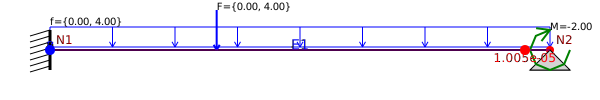

In [14]:
# plot deformed shape (after solved)
flip.plot_model_drawsvg(domain, width_px=600, height_px=100, show_deformed=True, deform_scale=1.e2, margin=50)

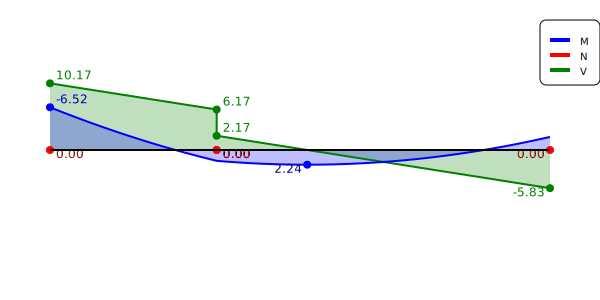

In [15]:
#  plot internal forces
flip.plot_internal_forces_on_structure (domain, diagrams=["N", "V", "M"], scale=0.4, width_px=600, height_px=300, margin=50)